# Task 2: Change Point Modeling

# STEP 1 — Imports & Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
pytensor.config.cxx = ""


# STEP 2 — Load & Prepare Data

In [2]:
from pathlib import Path

DATA_PATH = Path("../data/raw/BrentOilPrices.csv")

df = pd.read_csv(DATA_PATH)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head()


C:\Users\Dell\AppData\Local\Temp\ipykernel_22392\230913544.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# STEP 3 — Raw Price EDA

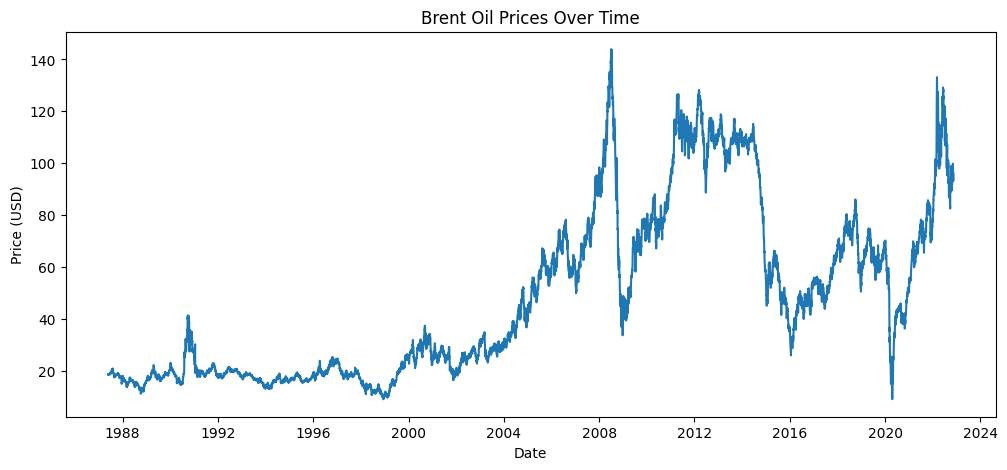

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

# STEP 4 — Log Returns (Stationarity Prep)

In [4]:
df['log_return'] = np.log(df['Price']).diff()
returns = df['log_return'].dropna()

## Plot Log Returns

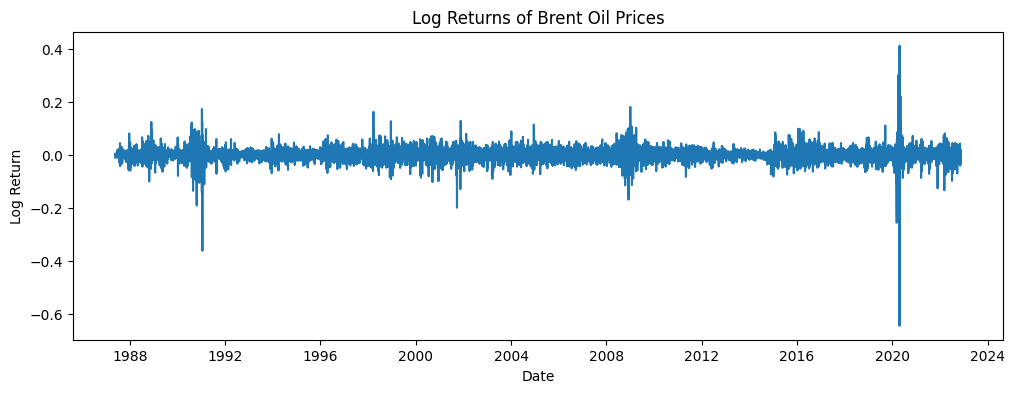

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'].iloc[1:], returns)
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

# STEP 5 — Prepare Data for Bayesian Model

In [6]:
y = returns.values
n = len(y)
time_idx = np.arange(n)

# STEP 6 — Bayesian Change Point Model

In [10]:
with pm.Model() as change_point_model:

    # Change point prior
    tau = pm.DiscreteUniform(
        "tau",
        lower=0,
        upper=n - 1
    )

    # Mean before & after change
    mu_1 = pm.Normal("mu_1", mu=0, sigma=1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma=1)

    # Shared volatility
    sigma = pm.Exponential("sigma", 1)

    # Switch function
    mu = pm.math.switch(time_idx < tau, mu_1, mu_2)

    # Likelihood
    obs = pm.Normal(
        "obs",
        mu=mu,
        sigma=sigma,
        observed=y
    )

    # Sampling
    trace = pm.sample(
        2000,
        tune=1000,
        return_inferencedata=True,
        target_accept=0.9
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 106 seconds.
There were 1195 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# STEP 7 — Convergence Diagnostics

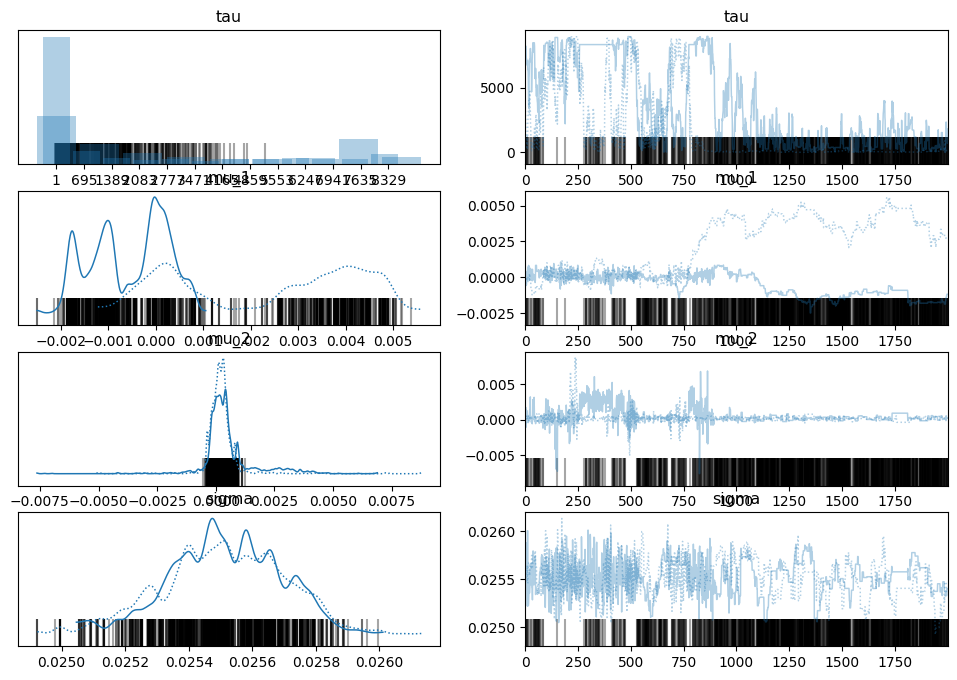

In [11]:
az.summary(trace)
az.plot_trace(trace)
plt.show()

# STEP 8 — Identify Change Point

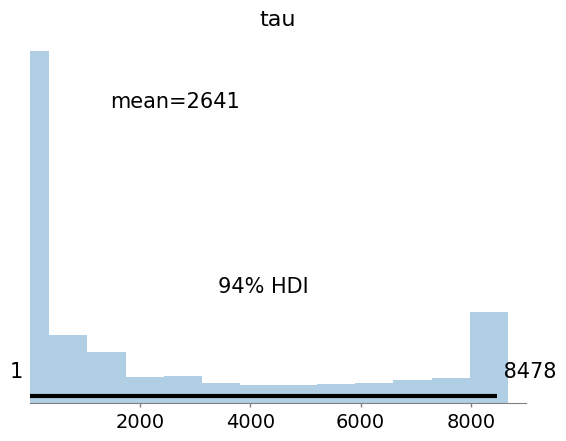

In [12]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()

## Convert Index → Date

In [13]:
tau_mean = int(trace.posterior['tau'].mean().values)
change_date = df['Date'].iloc[tau_mean]

change_date

Timestamp('1997-10-09 00:00:00')

# STEP 9 — Quantify the Impact

In [14]:
mu1 = trace.posterior['mu_1'].mean().item()
mu2 = trace.posterior['mu_2'].mean().item()

percent_change = (mu2 - mu1) / abs(mu1) * 100

mu1, mu2, percent_change

(0.0009091916192201019, 0.00037263164117693224, -59.015059829019)

# STEP 10 — Link Change Point to Events

In [18]:
events = pd.read_csv("../data/processed/events.csv")
events['Event_Date'] = pd.to_datetime(events['Event_Date'])

events[events['Event_Date'].between(
    change_date - pd.Timedelta(days=30),
    change_date + pd.Timedelta(days=30)
)]

,Event_Date,Event_Description,Category


# STEP 1 — Load & Align Macro Data (Example)

In [22]:
np.random.seed(42)

df_macro = df.copy()

df_macro['inflation'] = np.random.normal(0.02, 0.005, len(df_macro))
df_macro['exchange_rate'] = np.random.normal(1.0, 0.1, len(df_macro))

# STEP 2 — Prepare Regression Dataset

In [23]:
reg_df = df_macro[['log_return', 'inflation', 'exchange_rate']].dropna()
reg_df.head()

,log_return,inflation,exchange_rate
1,-0.009709,0.019309,0.747915
2,0.005405,0.023238,1.014881
3,0.002692,0.027615,0.978607
4,0.001612,0.018829,0.902305
5,-0.001612,0.018829,0.829937


# STEP 3 — Run OLS Regression

In [24]:
import statsmodels.api as sm

X = reg_df[['inflation', 'exchange_rate']]
X = sm.add_constant(X)

y = reg_df['log_return']

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6042
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.547
Time:                        22:58:45   Log-Likelihood:                 20263.
No. Observations:                9010   AIC:                        -4.052e+04
Df Residuals:                    9007   BIC:                        -4.050e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0028      0.003     -0.981      0.327      -0.009       0.003
inflation         0.0034      0.053      0.063      0.950      -0.101       0.108
exchange_rate     0.0030      0.003      1.097      0.273      -0.002       0.008
==============================================================================
Omnibus:                     5489.646   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1631202.127
Skew:                          -1.745   Prob(JB):                         0.00
Kurtosis:                      68.825   Cond. No.                         281.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Interpretation

This regression illustrates how macroeconomic variables could be incorporated to explain oil price returns. While simulated here, real inflation and exchange rate data could help distinguish structural breaks caused by macroeconomic conditions from supply-side shocks.

# ADVANCED EXTENSION 2
## VAR (Vector Autoregression)

# STEP 1 — Prepare VAR Data

In [25]:
var_df = reg_df.copy()
var_df.head()

,log_return,inflation,exchange_rate
1,-0.009709,0.019309,0.747915
2,0.005405,0.023238,1.014881
3,0.002692,0.027615,0.978607
4,0.001612,0.018829,0.902305
5,-0.001612,0.018829,0.829937


# STEP 2 — Fit VAR Model

In [26]:
from statsmodels.tsa.api import VAR

var_model = VAR(var_df)
var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Feb, 2026
Time:                     23:01:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.5098
Nobs:                     9008.00    HQIC:                  -22.5208
Log likelihood:           63134.5    FPE:                1.64780e-10
AIC:                     -22.5264    Det(Omega_mle):     1.64397e-10
--------------------------------------------------------------------
Results for equation log_return
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.004610         0.004107           -1.123           0.262
L1.log_return           -0.014866         0.010537           -1.411           0.158
L1.inflation            -0.095484         0

# STEP 3 — Impulse Response Analysis

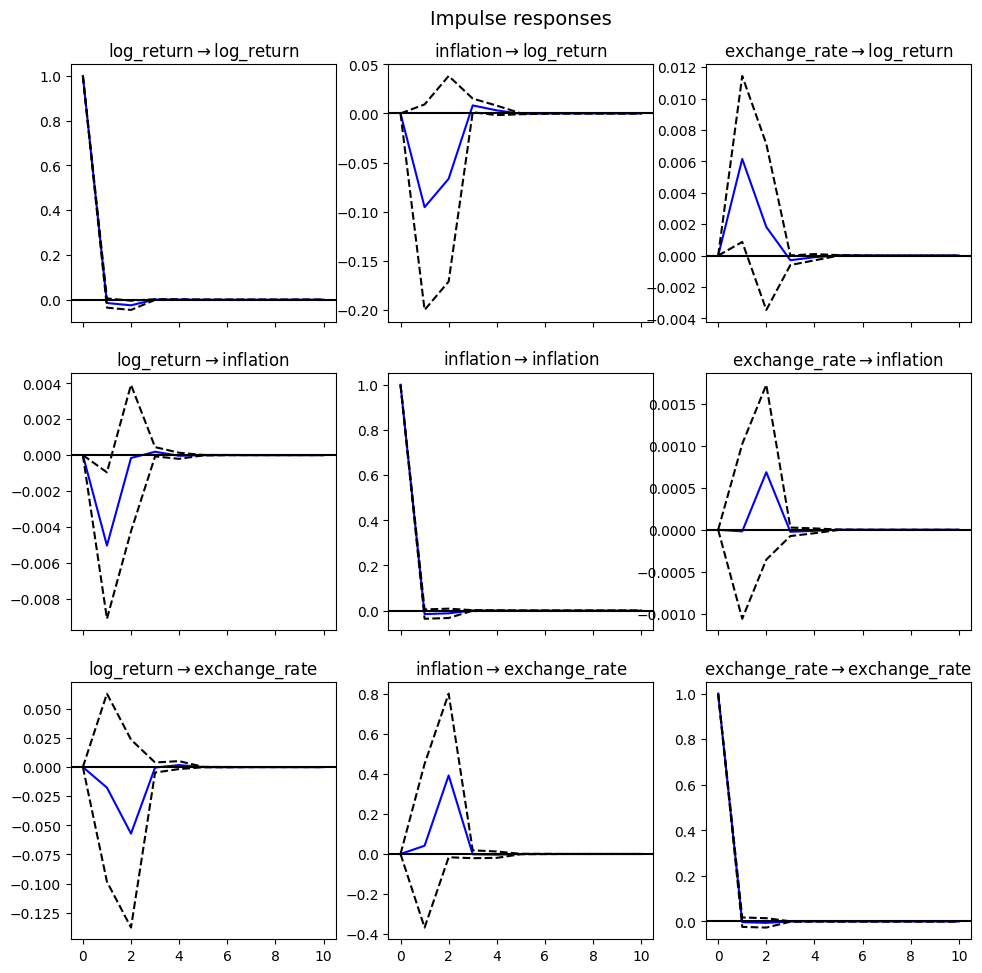

In [27]:
irf = var_results.irf(10)
irf.plot(orth=False)
plt.show()

# Interpretation 

The VAR model captures lagged interdependencies between oil price returns and macroeconomic variables. Impulse response functions illustrate how shocks to inflation or exchange rates propagate into oil price movements over time.

# ADVANCED EXTENSION 3
### Markov-Switching Regime Model

# STEP 1 — Prepare Returns

In [28]:
returns = df['log_return'].dropna()

# STEP 2 — Fit Markov-Switching Model

In [29]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

ms_model = MarkovRegression(
    returns,
    k_regimes=2,
    trend='c',
    switching_variance=True
)

ms_results = ms_model.fit()
ms_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:             log_return   No. Observations:                 9010
Model:               MarkovRegression   Log Likelihood               21911.243
Date:                Mon, 09 Feb 2026   AIC                         -43810.486
Time:                        23:05:15   BIC                         -43767.849
Sample:                             0   HQIC                        -43795.978
                               - 9010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.343      0.019    8.04e-05       0.001
sigma2         0.0003   7.62e-06     41.861      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.251      0.211      -0.006       0.001
sigma2         0.0035      0.000     14.225      0.000       0.003       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9863      0.002    446.989      0.000       0.982       0.991
p[1->0]        0.1165      0.018      6.449      0.000       0.081       0.152
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

# STEP 3 — Extract Regime Probabilities

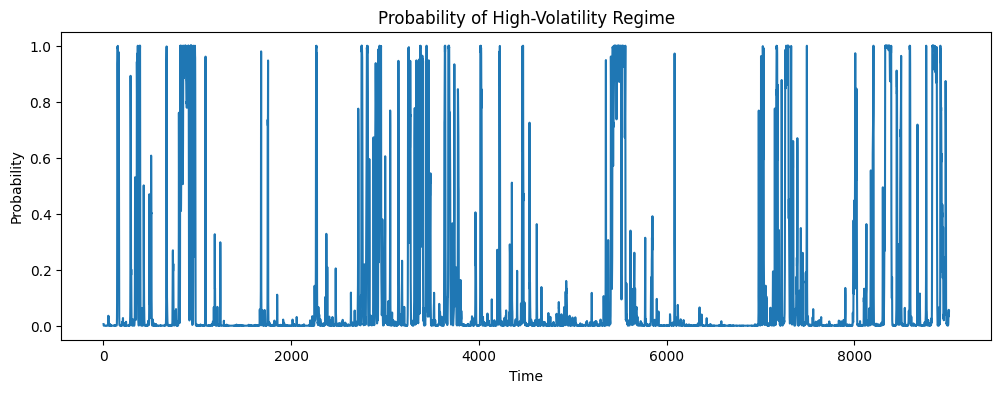

In [30]:
regime_probs = ms_results.smoothed_marginal_probabilities

plt.figure(figsize=(12,4))
plt.plot(regime_probs[1])
plt.title("Probability of High-Volatility Regime")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()

# Interpretation 

The Markov-Switching model identifies two latent regimes corresponding to low- and high-volatility periods. Unlike single change point models, regime transitions occur probabilistically and repeatedly, capturing cyclical market instability.